# Import python packages 


In [1]:
import planetary_computer
import xarray as xr
import fsspec
import pystac_client

import matplotlib.pyplot as plt
import numpy as np

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.mpl.ticker as cticker


## Accessing NEX-GDDP-CMIP6 data with the Planetary Computer STAC API

https://github.com/microsoft/PlanetaryComputerExamples/blob/main/datasets/nasa-nex-gddp-cmip6/nasa-nex-gddp-cmip6-example.ipynb

The NEX-GDDP-CMIP6 dataset offers global downscaled climate scenarios derived from the General Circulation Model (GCM) runs conducted under the Coupled Model Intercomparison Project Phase 6 (CMIP6) and across two of the four “Tier 1” greenhouse gas emissions scenarios known as Shared Socioeconomic Pathways (SSPs). The purpose of this dataset is to provide a set of global, high resolution, bias-corrected climate change projections that can be used to evaluate climate change impacts on processes that are sensitive to finer-scale climate gradients and the effects of local topography on climate conditions.

This dataset uses a Bias-Correction Spatial Disaggregation method to downscale the original General Circulation Model runs to the finer 0.25° resolution. See the tech note from the product homepage for more details.

The NEX-GDDP-CMIP6 files are stored as NetCDF in Azure Blob Storage. Each STAC Item in this collection describes a single year for one scenario for one model.



In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [3]:
collection = catalog.get_collection("nasa-nex-gddp-cmip6")

# List the scenarios
collection.summaries.get_list("cmip6:scenario")

# list the variables
#collection.summaries.get_list("cmip6:variable")

['historical', 'ssp245', 'ssp585']

In [4]:
search = catalog.search(
    collections=["nasa-nex-gddp-cmip6"],
    datetime="1950/2000", 
    query={"cmip6:model": {"eq": "HadGEM3-GC31-LL"}},
)
items = search.item_collection()
item_yr_2000, item_yr_1950 = items[0], items[50]

In [5]:
item_yr_2000, item_yr_1950 = items[0], items[50]

In [6]:
pr_2000 = xr.open_dataset(fsspec.open(item_yr_2000.assets["pr"].href).open())
pr_1950 = xr.open_dataset(fsspec.open(item_yr_1950.assets["pr"].href).open())


# Daily Mean Precip
calculate the precipitation climatology, we can make use of the fact that xarray DataArrays have built in functionality for averaging over their dimensions.

In [7]:
clim = pr_2000['pr'].mean('time', keep_attrs=True)
print(clim)

<xarray.DataArray 'pr' (lat: 600, lon: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -59.88 -59.62 -59.38 -59.12 ... 89.38 89.62 89.88
  * lon      (lon) float64 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Attributes:
    standard_name:  precipitation_flux
    long_name:      Precipitation
    units:          kg m-2 s-1
    comment:        includes both liquid and solid phases
    original_name:  mo: (stash: m01s05i216, lbproc: 128)
    cell_methods:   area: time: mean
    cell_measures:  area: areacella


## Convert pr to mm per day

Convert the units from kg m-2 s-1 to something that we are a little more familiar with like mm day-1.

To do this, consider that 1 kg of rain water spread over 1 m2 of surface is 1 mm in thickness and that there are 86400 seconds in one day. Therefore, 1 kg m-2 s-1 = 86400 mm day-1.

In [8]:
clim.data = clim.data * 86400
clim.attrs['units'] = ' Precipitation (mm/day)' 

#print(clim)

## Visualize Daily Global Mean Precip Over greater than global daily average of 2mm/day

/home/lcarte2/.conda/envs/clim_data/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1714: UserWarning: Log scale: values of z <= 0 have been masked
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)


Text(0.5, 1.0, 'NEX-GDDP-CMIP6-HADGEM3-GC31-LL Historical (2000) Daily Precip. Average')

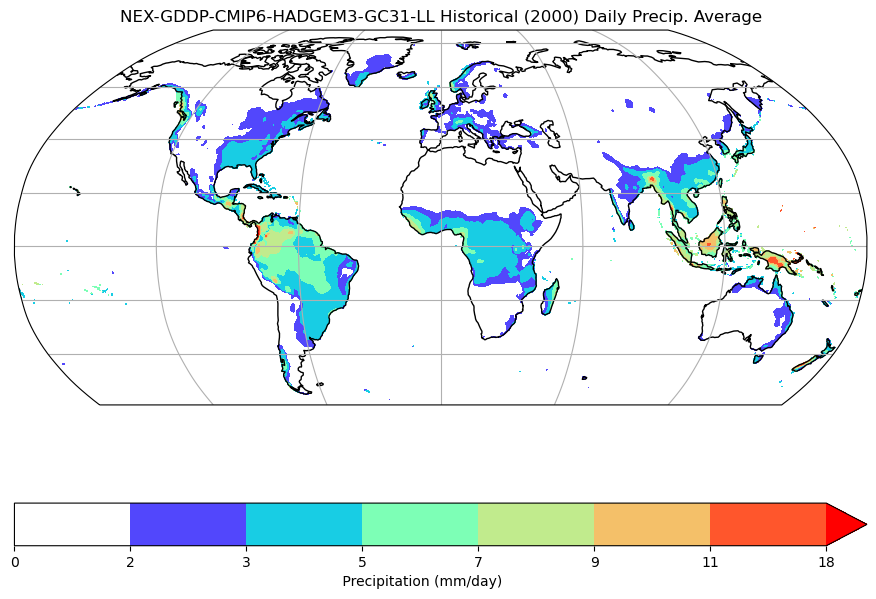

In [9]:
from matplotlib import colors
fig = plt.figure(figsize=(11,8.5))

# N = 100
# X, Y = np.mgrid[-3:3:complex(0, N), -2:2:complex(0, N)]

# # A low hump with a spike coming out of the top right.  Needs to have
# # z/colour axis on a log scale, so we see both hump and spike. A linear
# # scale only shows the spike.
# Z1 = np.exp(-X**2 - Y**2)
# Z2 = np.exp(-(X * 10)**2 - (Y * 10)**2)
# Z = Z1 + 50 * Z2


#ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.Robinson())

# draw filled contours.daily global precip ~2mm/day
clevs = [0, 2, 3, 5, 7, 9, 11, 18] #https://climatedataguide.ucar.edu/climate-data/precipitation-data-sets-overview-comparison-table#:~:text=Adler%20et%20al%20(2012)%20estimate,%C2%B1%207%25%20mm%2Fday.
# In future MetPy

cs = ax.contourf(clim['lon'], clim['lat'], clim, clevs, extend='max', transform=ccrs.PlateCarree(), cmap='rainbow', norm=colors.LogNorm())
# Add coastlines
ax.coastlines()

# Add gridlines
ax.gridlines()
# add colorbar.
cbar = plt.colorbar(cs, orientation='horizontal')
cbar.set_label(clim.units)

plt.title('NEX-GDDP-CMIP6-HADGEM3-GC31-LL Historical (2000) Daily Precip. Average')
